# Experiment some machine learning models

In [1]:
# import necessary packages
import warnings
warnings.filterwarnings('ignore')

import logging
import tempfile
from io import BytesIO
import pandas as pd
from decimal import Decimal
import numpy as np
import datetime
import mlflow
import math
# import matplotlib.pyplot as plt
# import seaborn as sns
import pickle
import io
import joblib
import boto3
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, RocCurveDisplay, roc_auc_score, precision_recall_curve

from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset
from evidently.metrics import *

from evidently.test_suite import TestSuite
from evidently.tests import *

In [2]:
# read train set as a pandas dataframe
full_set = pd.read_csv('../data/dataset.csv')
train_set = pd.read_csv('../data/train_set.csv')
test_set = pd.read_csv('../data/test_set.csv')

In [7]:
# select only the features that we are going to use
X = train_set.drop(['fraude'], axis=1)
y = train_set['fraude']

# Preprocessing

In [8]:
class CountryMapper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def map_countries(country):
            if country == 'BR':
                return 'BR'
            elif country == 'AR':
                return 'AR'
            elif country == 'UY':
                return 'UY'
            elif country == 'US':
                return 'US'
            else:
                return 'outros'
        
        X['pais'] = X['pais'].apply(map_countries)
        return X
    
    def get_feature_names_out(self, X):
        return ['pais']

In [9]:
qualitative_feat = ['score_1', 'entrega_doc_1']
entrega_doc_2_feat = ['entrega_doc_2']
entrega_doc_3_feat = ['entrega_doc_3']
pais_feat = ['pais']

# quantitative_continue_feat = [
#     'score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_9', 'score_10', 'valor_compra']

quantitative_continue_feat = [
    'score_4', 'score_9', 'score_10', 'valor_compra']

qualitative_preproc = make_pipeline(
        SimpleImputer(strategy='most_frequent'))

entrega_doc_2_preproc = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='null'),
        OneHotEncoder(drop='first'))

entrega_doc_3_preproc = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(drop='if_binary'))

pais_preproc = make_pipeline(
        CountryMapper(),
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(drop='first'))

quantitative_continue_preproc = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler())

# apply the respective transformations with columntransformer method
preprocessor = ColumnTransformer([
    ('entrega_doc_1_feat', qualitative_preproc, qualitative_feat),
    ('entrega_doc_2_feat', entrega_doc_2_preproc, entrega_doc_2_feat),
    ('entrega_doc_3_feat', entrega_doc_3_preproc, entrega_doc_3_feat),
    ('pais_feat', pais_preproc, pais_feat),
    ('quantitative_continue_feat', quantitative_continue_preproc, quantitative_continue_feat)],
    remainder='drop')

processed_features = qualitative_feat + entrega_doc_2_feat + entrega_doc_3_feat + pais_feat + quantitative_continue_feat

# Baseline and business return of the last model

In [10]:
def map_score(score_fraude, threshold):
    if score_fraude >= threshold:
        return 1
    else:
        return 0

# list to store the metrics
thresholds = []
train_balanced_accuracies = []
test_balanced_accuracies = []
revenue = []
loss = []
profit = []

# create a copy
business_return = test_set.copy()

# calculate the predictions for different thresholds
for threshold in range(101):
    business_return[f'y_pred_last_model_{threshold}'] = business_return['score_fraude_modelo'].apply(lambda x: map_score(x, threshold))

    # calculate the accuracies
    test_balanced_accuracy = balanced_accuracy_score(business_return['fraude'], business_return[f'y_pred_last_model_{threshold}'])

    # calculate the revenue
    revenues = business_return.loc[(test_set['fraude'] == 0) &
                                   (business_return[f'y_pred_last_model_{threshold}'] == 0)]
    total_revenue = np.sum(revenues['valor_compra'].values)
    total_revenue = total_revenue * 0.1

    # calculate the fraud losses
    losses = business_return.loc[(business_return['fraude'] == 1) &
                                 (business_return[f'y_pred_last_model_{threshold}'] == 0)]
    total_losses = np.sum(losses['valor_compra'].values)

    # calculate the profit
    total_profit = total_revenue - total_losses

    # put the values in lists
    thresholds.append(threshold)
    test_balanced_accuracies.append(test_balanced_accuracy)
    revenue.append(total_revenue)
    loss.append(total_losses)
    profit.append(total_profit)

# Criar o DataFrame com as métricas
metrics_df = pd.DataFrame({
    'Threshold': thresholds,
    'Test_Balanced_Accuracy': test_balanced_accuracies,
    'Revenue': revenue,
    'Fraud_losses': loss,
    'Profit': profit
})

In [11]:
metrics_df

,Threshold,Test_Balanced_Accuracy,Revenue,Fraud_losses,Profit
0,0,0.500000,0.000,0.00,0.000
1,1,0.504955,2271.893,768.72,1503.173
2,2,0.504769,2802.762,1478.48,1324.282
3,3,0.506289,3452.885,1556.61,1896.275
4,4,0.507663,4159.779,1765.88,2393.899
...,...,...,...,...,...
96,96,0.577211,85270.137,69149.72,16120.417
97,97,0.564459,85840.909,71841.57,13999.339
98,98,0.553193,86260.620,74507.02,11753.600
99,99,0.545383,86748.330,76973.81,9774.520


In [12]:
# showing the best profit
metrics_df.loc[(metrics_df['Profit'] == metrics_df.Profit.values.max())]

,Threshold,Test_Balanced_Accuracy,Revenue,Fraud_losses,Profit
79,79,0.709871,67041.923,25316.65,41725.273


# Setting up MLFlow Experiments

In [13]:
# # Setting up the mlflow experiment
# experiment_path = 'mlflow_experiments' # Defining the path of experiments in MLFlow
# experiment_name = '19_fraud_detection' # Defining the experiment name in MLFlow

# if(not(mlflow.get_experiment_by_name(experiment_name))): # If the experiment does not exist, create it
#     mlflow.create_experiment(experiment_name)
    
# mlflow.set_experiment(experiment_name) # Set the current experiment to register in MLFlow

In [14]:
# Setting current date to save
year = str(datetime.today().year)
month = str(datetime.today().month)
if len(month) == 1:
    month = "0" + month
day = str(datetime.today().day)
if len(day) == 1:
    day = "0" + day
date = year + "/" + month + "/" + day 

AttributeError: module 'datetime' has no attribute 'today'

# Training and Model Selection

In [ ]:
def run_classifier_models(X, y, cv, scoring):
    '''Função que treina os seguintes modelos de machine learning:
    RandomForestClassifier, DecisionTreeClassifier, SGDClassifier, SVC,
    LGBMClassifier, GaussianNB.
    A função aplica a validação cruzada no conjunto de dados e retorna a média
    da métrica selecionada no conjunto de treino e validação.
    As únicas métricas ativas são Acurácia e F1 score.
    Os experimentos com os modelos são acompanhados pelo MLflow.
    
    :param X: (dataframe or numpy array) 
    Dataframe ou array com o conjunto de variáveis independentes.
    
    :param y: (series or numpy array)
    Coluna ou array com a variável dependente.
    
    :param cv: (int)
    Determina a estratégia de divisão de validação cruzada.
    
    :param scoring: (str)
    Estratégia para avaliar o desempenho do modelo de validação cruzada no conjunto de validação.
    Deve ser passada entre aspas ao chamar a função.
    '''
    # 1. Instantiate the models
    lr = LogisticRegression(random_state=42)
    rf = RandomForestClassifier(random_state=42)
    dt = DecisionTreeClassifier(random_state=42)
    # sgdc = SGDClassifier(random_state=42)
    # svc = SVC(random_state=42)
    # gnb = GaussianNB()
    # ada = AdaBoostClassifier(random_state=42)

    # 2. train and evaluate the models
    for model in (lr, rf, dt):
        pipe = Pipeline(
            steps=[('preprocessor', preprocessor),
                   ('under', RandomUnderSampler(random_state=42)),
                   ('classifier', model)
            ]
        )
        scores = cross_validate(pipe, X, y, return_train_score=True,
                                scoring=scoring, cv=cv)

        # train and validation with accuracy
        if scoring == 'balanced_accuracy':
            log_train_acc = np.mean(scores['train_score'])
            log_test_acc = np.mean(scores['test_score'])

            # track the experiment with accuraccy
            mlflow.start_run(run_name = date) 
            mlflow.log_param('Date', date) 
            mlflow.log_param('Features', X.columns)
            # mlflow.log_param('Pre-processing', preprocessor) 
            mlflow.log_param('ML model', pipe[2])

            mlflow.log_metric('Train_acc', log_train_acc)
            mlflow.log_metric('Test_acc', log_test_acc)

            mlflow.end_run()

        # train and validation with f1
        if scoring == 'f1':
            log_train_f1 = np.mean(scores['train_score'])
            log_test_f1 = np.mean(scores['test_score'])

            # track the experiment with f1 score
            mlflow.start_run(run_name = date) 
            mlflow.log_param('Date', date) 
            mlflow.log_param('Features', X.columns)
            # mlflow.log_param('Pre-processing', preprocessor) 
            mlflow.log_param('ML model', pipe[2])

            mlflow.log_metric('Train_f1', log_train_f1)
            mlflow.log_metric('Test_f1', log_test_f1)

            mlflow.end_run()

In [ ]:
# Run classifiers
run_classifier_models(X, y, 5, 'f1')

In [ ]:
# !mlflow ui

In [ ]:
# mlflow.end_run()

# Improve the Model

In [ ]:
# Hyperparameter tunning
# 1. Instantiate the pipeline
final_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('under', RandomUnderSampler(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ]
)

# 2. Hyperparameter interval to be tested
param_grid = {
    'rf__n_estimators': [150],
    'rf__max_depth': [8],
    'under__sampling_strategy': [0.5]
}

# 3. Training and apply grid search with cross-validation
grid_search = GridSearchCV(
    final_model, 
    param_grid, 
    cv=5, 
    scoring=['balanced_accuracy', 'f1', 'neg_brier_score'], 
    refit='neg_brier_score',
    return_train_score=True)
grid_search.fit(X, y)

# Seeing the best hyperparameters for the model
print('The best hyperparameters were:', grid_search.best_params_)

The best hyperparameters were: {'rf__max_depth': 8, 'rf__n_estimators': 150, 'under__sampling_strategy': 0.5}


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
metrics = ['balanced_accuracy', 'f1', 'neg_brier_score']
best_metrics = {}

print("\nBest metrics for each calculated metric:\n")
for metric in metrics:
    best_train_metric = results[f'mean_train_{metric}'][grid_search.best_index_]
    best_val_metric = results[f'mean_test_{metric}'][grid_search.best_index_]
    print(f"Best training {metric}: {best_train_metric:.4f}")
    print(f"Best validation {metric}: {best_val_metric:.4f}")

    best_metrics[f'train_{metric}'] = best_train_metric
    best_metrics[f'validation_{metric}'] = best_val_metric


Best metrics for each calculated metric:

Best training balanced_accuracy: 0.7525
Best validation balanced_accuracy: 0.7332
Best training f1: 0.3407
Best validation f1: 0.3209
Best training neg_brier_score: -0.0934
Best validation neg_brier_score: -0.0952


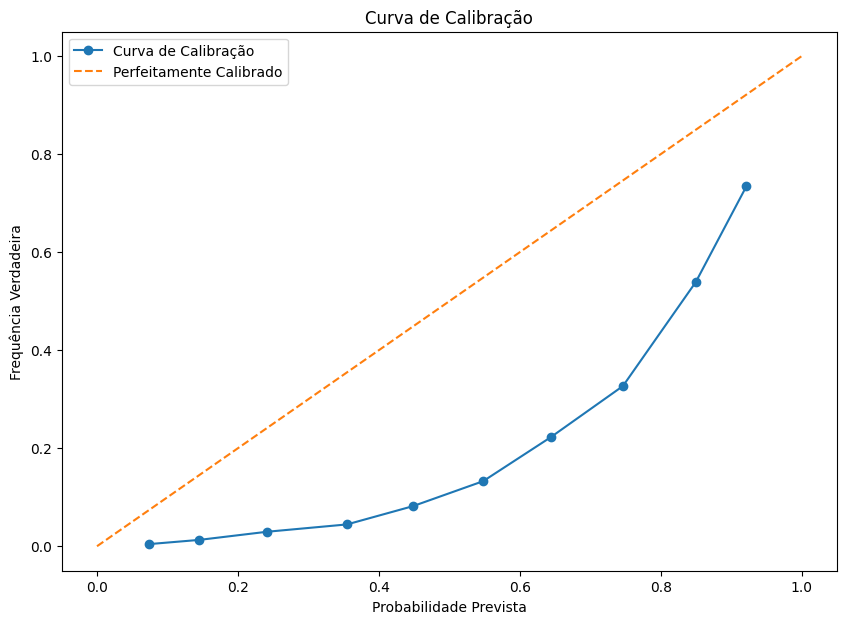

Brier score: 0.09326150867186922


In [ ]:
from sklearn.calibration import calibration_curve

# 1. Obter o melhor modelo do GridSearchCV
best_model = grid_search.best_estimator_

# 2. Fazer previsões de probabilidade com o melhor modelo
y_probs = best_model.predict_proba(X)[:, 1]

# 3. Calcular a curva de calibração
prob_true, prob_pred = calibration_curve(y, y_probs, n_bins=10)

# 4. Plotar a curva de calibração
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', label='Curva de Calibração')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfeitamente Calibrado')
plt.xlabel('Probabilidade Prevista')
plt.ylabel('Frequência Verdadeira')
plt.title('Curva de Calibração')
plt.legend()
plt.show()

# 5. Calcular e imprimir a pontuação de Brier
from sklearn.metrics import brier_score_loss
brier_score = brier_score_loss(y, y_probs)
print(f'Brier score: {brier_score}')

# Feature Importance and model interpretability

In [ ]:
# Get the best estimator from the grid search
rf = grid_search.best_estimator_.named_steps['rf']
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

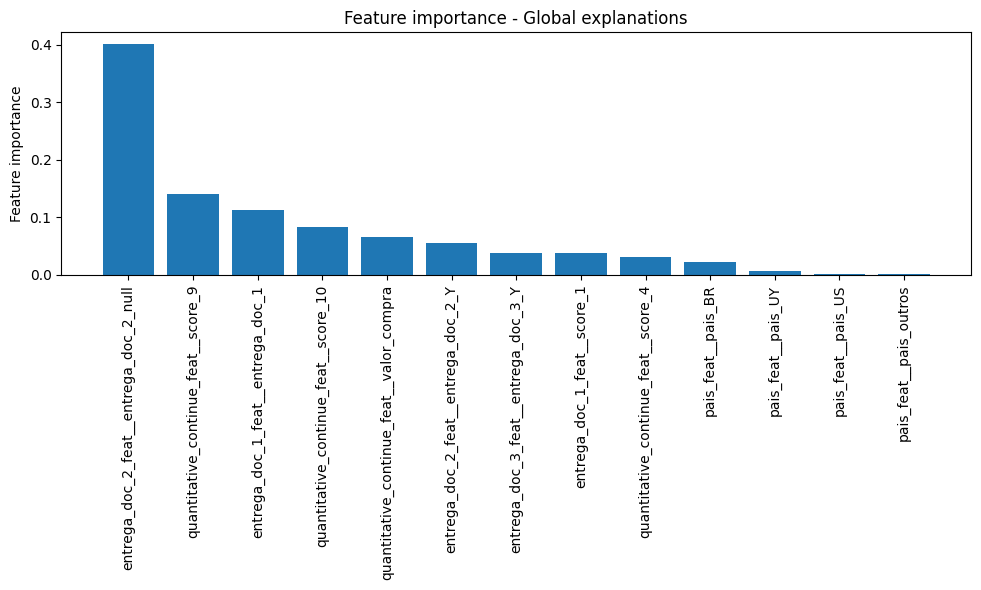

In [ ]:
def feature_importance_rf_plot(model, preprocessor, output_image_path) -> None:
    '''
    Generate and export a feature importance plot for the random forest model.

    Args:
        model (RandomForestClassifier): The trained RandomForest model.
        preprocessor (ColumnTransformer): The preprocessor used in the pipeline.
        output_image_path (str): The path to save the output image.

    Returns:
        None
    '''
    # Importance based on each tree
    global_exp = pd.DataFrame([tree.feature_importances_ for tree in model.estimators_]).T
    global_exp.columns = [f'tree_{i+1}' for i in range(model.n_estimators)]

    # Set the feature names as indices of the DataFrame
    global_exp.index = preprocessor.get_feature_names_out()

    # Calculate the mean importance of features across all trees
    global_exp['importance'] = global_exp.mean(axis=1)

    # Sort the DataFrame by the 'importance' column in descending order and
    # plot it
    global_exp_sorted = global_exp.sort_values(by='importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(global_exp_sorted.index, global_exp_sorted['importance'])
    plt.ylabel("Feature importance")
    plt.title("Feature importance - Global explanations")
    plt.xticks(rotation=90)

    # Adjust the layout to prevent cutting off elements
    plt.tight_layout()

    # Save the plot as an image file
    plt.savefig(output_image_path)
    plt.show()


feature_importance_rf_plot(rf, preprocessor, 'feature_importance.png')

# Evaluate new model in test set

In [ ]:
# select only the features that we are going to use
X_test = test_set.drop(['fraude'], axis=1)
y_test = test_set['fraude']

In [ ]:
# Evaluate final model
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.97      0.90      0.94     21353
           1       0.23      0.57      0.33      1147

    accuracy                           0.88     22500
   macro avg       0.60      0.73      0.63     22500
weighted avg       0.94      0.88      0.90     22500

0.7335566494232724


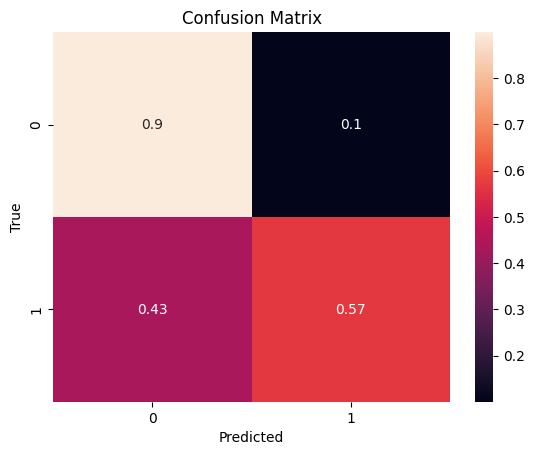

AUC: 0.7336



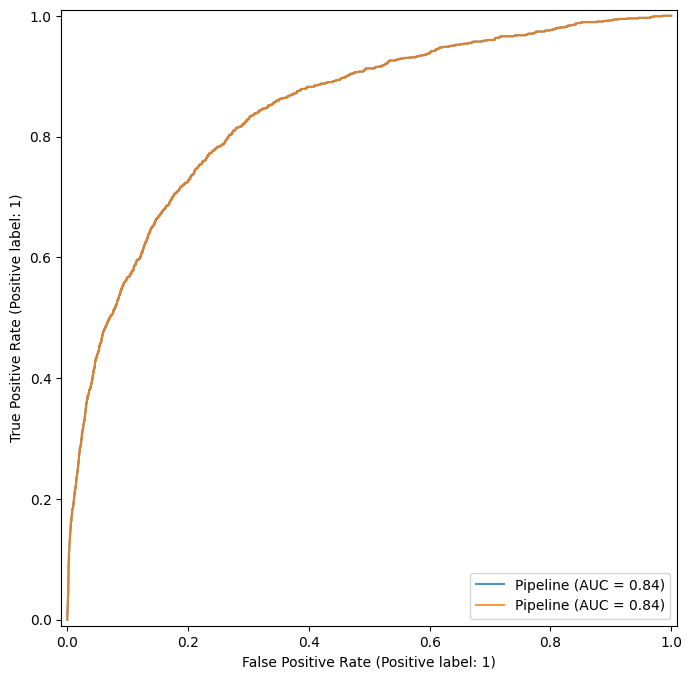

In [ ]:
# print classification report
print(classification_report(y_test, final_predictions))
print(balanced_accuracy_score(y_test, final_predictions))

# plot confusion matrix
fig , ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, final_predictions, normalize='true'), annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_ylabel("True")
ax.set_xlabel("Predicted")
plt.show()

# print and plot roc_auc
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, final_predictions)))

plt.figure(figsize=(15, 8))
ax = plt.gca()
lgbm_disp = RocCurveDisplay.from_estimator(final_model, X_test, y_test, ax=ax, alpha=0.8)
lgbm_disp.plot(ax=ax, alpha=0.8)
plt.show()

# Business return of the new model

In [ ]:
df_pred = pd.DataFrame({'y_test': y_test, 'final_predictions': final_predictions.reshape(-1)})
df_pred = pd.concat([X_test, df_pred], axis=1)

In [ ]:
# calculate the revenue
revenues_new_model = df_pred.loc[(df_pred['y_test'] == 0) &
                                 (df_pred['final_predictions'] == 0)]
total_revenue_new_model = np.sum(revenues_new_model['valor_compra'].values)
total_revenue_new_model = total_revenue_new_model * 0.1

# calculate the fraud losses
losses_new_model = df_pred.loc[(df_pred['y_test'] == 1) &
                               (df_pred['final_predictions'] == 0)]
total_losses_new_model = np.sum(losses_new_model['valor_compra'].values)

# calculate the profit
total_profit_new_model = total_revenue_new_model - total_losses_new_model
total_profit_new_model

45636.363

In [ ]:
total_buy_value = np.sum(test_set['valor_compra'].values)

In [ ]:
last_model_percentage = (41725.273 / total_buy_value) * 100
new_model_percentage = (total_profit_new_model / total_buy_value) * 100

print('We increased the percentage of profit in:', new_model_percentage - last_model_percentage, '%')

We increased the percentage of profit in: 0.4044866684841084 %


# Read table in DynamoDB

In [ ]:
# Configuração do cliente S3
s3_client = boto3.client('s3')
print('S3 authentication was created successfully.')

# Nome do bucket
BUCKET_NAME_DATA = 'ct-fraud-data-bucket'

# Listar todos os arquivos no bucket
response = s3_client.list_objects_v2(Bucket=BUCKET_NAME_DATA)

# Lista para armazenar dataframes
dataframes = []

# Iterar sobre os arquivos e ler os arquivos .csv que começam com 'dataset'
for obj in response['Contents']:
    key = obj['Key']
    if key.startswith('dataset') and key.endswith('.csv'):
        print(f'Reading {key} from S3 bucket.')
        csv_obj = s3_client.get_object(Bucket=BUCKET_NAME_DATA, Key=key)
        df = pd.read_csv(csv_obj['Body'])
        dataframes.append(df)
        print(f'Dataset {key} loaded successfully.')

# Concatenar todos os dataframes em um único dataframe
unified_dataframe = pd.concat(dataframes, ignore_index=True)

print('All datasets have been concatenated into a single dataframe.')

S3 authentication was created successfully.
Reading dataset.csv from S3 bucket.
Dataset dataset.csv loaded successfully.
All datasets have been concatenated into a single dataframe.


In [ ]:
# Suponha que estas sejam as colunas que você deseja testar
selected_columns = ['score_1', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3', 'pais', 'score_4', 'score_9', 'score_10', 'valor_compra', 'fraude']

# Filtrando as colunas nos conjuntos de dados de treino e teste
train_set_selected = train_set[selected_columns]
test_set_selected = test_set[selected_columns]

# Generate evidently data drift report
drift_report = Report(metrics=[
    DataDriftPreset(),
])

drift_report.run(reference_data=train_set_selected, current_data=test_set_selected)
drift_report.save_html('data_drift_report.html')
print('Generate data drift report: SUCCESS')

# Generate evidently data stability report
stability_tests = TestSuite(tests=[
    TestNumberOfColumnsWithMissingValues(),
    TestNumberOfRowsWithMissingValues(),
    TestNumberOfConstantColumns(),
    TestNumberOfDuplicatedRows(),
    TestNumberOfDuplicatedColumns(),
    TestColumnsType(),
    TestNumberOfDriftedColumns(),
])

stability_tests.run(reference_data=train_set_selected, current_data=test_set_selected)
stability_tests.save_html('data_stability_report.html')
print('Generate data stability report: SUCCESS')

Generate data drift report: SUCCESS
Generate data stability report: SUCCESS


In [4]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def generate_evidently_reports(current_dataset: pd.DataFrame, reference_dataset: pd.DataFrame, selected_columns: list, bucket_name: str):
    """
    Generate data drift and stability reports using Evidently for selected columns and upload to S3.

    Parameters:
        current_dataset (pd.DataFrame): The current dataset.
        reference_dataset (pd.DataFrame): The reference dataset.
        selected_columns (list): List of column names to include in the reports.
        bucket_name (str): The name of the S3 bucket where reports will be uploaded.
    
    Returns:
        None
    """
    # Get the current date
    current_date = datetime.datetime.now().strftime('%Y-%m-%d')

    # Initialize the S3 client
    s3_client = boto3.client('s3')
    
    # Select specified columns from the datasets
    current_dataset_selected = current_dataset[selected_columns]
    reference_dataset_selected = reference_dataset[selected_columns]
    
    # Generate evidently data drift report
    drift_report = Report(metrics=[
        DataDriftPreset(),
    ])
    
    logging.info('Running data drift report...')
    drift_report.run(reference_data=reference_dataset_selected, current_data=current_dataset_selected)
    
    # Save to a temporary file and upload to S3
    with tempfile.NamedTemporaryFile(delete=False, suffix='.html') as tmp_file:
        drift_report.save_html(tmp_file.name)
        s3_client.upload_file(tmp_file.name, bucket_name, f'reports/data_drift_report_{current_date}.html')
    logging.info('Data drift report uploaded to S3 at reports/data_drift_report_%s.html', current_date)
    
    # Generate evidently data stability report
    stability_tests = TestSuite(tests=[
        TestNumberOfColumnsWithMissingValues(),
        TestNumberOfRowsWithMissingValues(),
        TestNumberOfConstantColumns(),
        TestNumberOfDuplicatedRows(),
        TestNumberOfDuplicatedColumns(),
        TestColumnsType(),
        TestNumberOfDriftedColumns(),
    ])
    
    logging.info('Running data stability report...')
    stability_tests.run(reference_data=reference_dataset_selected, current_data=current_dataset_selected)
    
    # Save to a temporary file and upload to S3
    with tempfile.NamedTemporaryFile(delete=False, suffix='.html') as tmp_file:
        stability_tests.save_html(tmp_file.name)
        s3_client.upload_file(tmp_file.name, bucket_name, f'reports/data_stability_report_{current_date}.html')
    logging.info('Data stability report uploaded to S3 at reports/data_stability_report_%s.html', current_date)

# Example usage
# Example column selection
selected_columns = ['score_1', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3', 'pais', 'score_4', 'score_9', 'score_10', 'valor_compra', 'fraude']

# S3 bucket name
bucket_name = 'ct-fraud-drift-report-bucket'

# Call the function
generate_evidently_reports(train_set, test_set, selected_columns, bucket_name)


2024-06-30 05:52:58,958 - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2024-06-30 05:52:59,219 - INFO - Running data drift report...
2024-06-30 05:53:10,940 - INFO - Data drift report uploaded to S3 at reports/data_drift_report_2024-06-30.html
2024-06-30 05:53:10,943 - INFO - Running data stability report...
2024-06-30 05:53:21,062 - INFO - Data stability report uploaded to S3 at reports/data_stability_report_2024-06-30.html
